In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.cof import COF
from pyod.utils.utility import standardizer
from pyod.models.lof import LocalOutlierFactor

In [106]:
df_hour = pd.read_csv("hour.csv")
df_hour.head()
df_day = pd.read_csv("day.csv")
df_day.head()
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])

In [107]:
df_day = pd.read_csv("day.csv")
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [108]:
df_hour["weekday"] = df_hour["weekday"].replace(0,7)
print(df_hour["weekday"].unique())
hour_data_update = df_hour.copy()
weekday_mapping = {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thrusday", 5:"Friday", 6:"Saturday", 7:"Sunday"}
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

hour_data_update["dayName"] = hour_data_update["weekday"].map(weekday_mapping)

[6 7 1 2 3 4 5]


In [109]:
#Method : 2
hour_data_update["dayName"] = hour_data_update["dteday"].dt.day_name()
print(hour_data_update[["dayName","weekday"]].head())

hour_data_update["monthName"] = hour_data_update["dteday"].dt.month_name()

season_mapping = {1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}
hour_data_update["seasonName"] = hour_data_update["season"].map(season_mapping)
hour_data_update["year"] = hour_data_update["dteday"].dt.year

if 'instant' in hour_data_update.columns:
    hour_data_update = hour_data_update.drop(columns="instant")

print(hour_data_update.columns)
season_order = ["Spring", "Summer", "Fall", "Winter"]
month_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]


    dayName  weekday
0  Saturday        6
1  Saturday        6
2  Saturday        6
3  Saturday        6
4  Saturday        6
Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'dayName', 'monthName', 'seasonName',
       'year'],
      dtype='object')


Anomaly Detection with LOF

Bike rentals per month

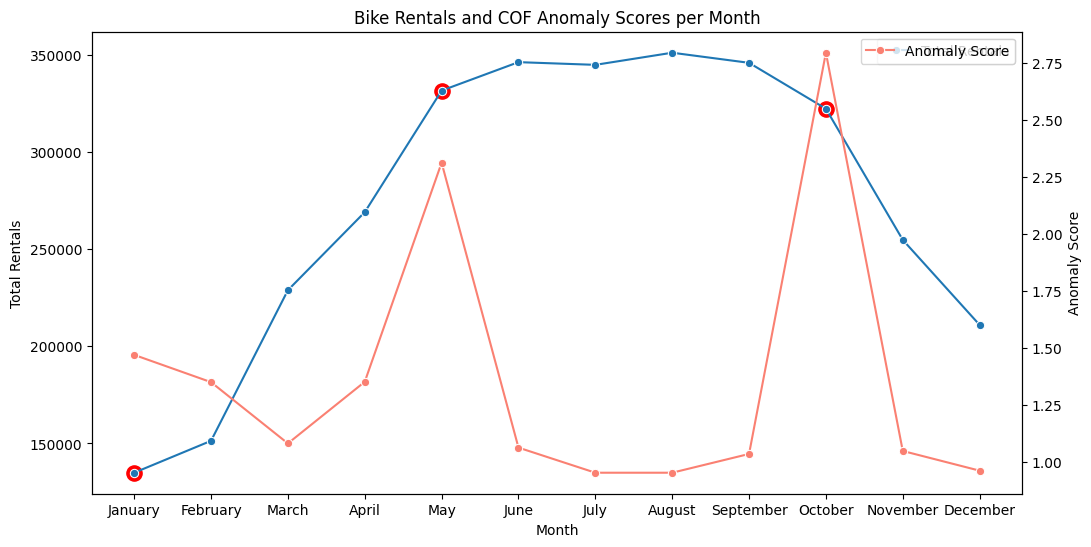

In [138]:
month_data = hour_data_update.groupby("monthName")["cnt"].sum().reindex(month_order).reset_index()
data_rentals = month_data[["cnt"]].values

data_std = standardizer(data_rentals)
# 25% anomalies as we have 4 seasons, so 1 out of 4
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.25)

month_data["AnomalyLabel"] = lof.fit_predict(data_std)
month_data["AnomalyLabel"] = month_data["AnomalyLabel"].map({1:0, -1:1})
month_data["AnomalyScore"] = -lof.negative_outlier_factor_

fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data=month_data, x="monthName", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=month_data, x="monthName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = month_data[month_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["monthName"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Month")
plt.show()

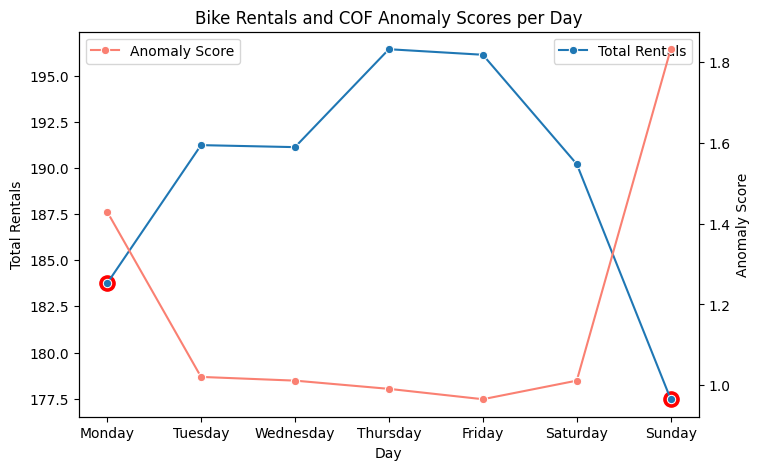

In [140]:
weekday_data = hour_data_update.groupby('dayName')['cnt'].mean().reindex(weekday_order).reset_index()
data_rentals = weekday_data[["cnt"]].values

data_std = standardizer(data_rentals)
# 25% anomalies as we have 4 seasons, so 1 out of 4
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.25)

weekday_data["AnomalyLabel"] = lof.fit_predict(data_std)
weekday_data["AnomalyLabel"] = weekday_data["AnomalyLabel"].map({1:0, -1:1})
weekday_data["AnomalyScore"] = -lof.negative_outlier_factor_

fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=weekday_data, x="dayName", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Day")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=weekday_data, x="dayName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = weekday_data[weekday_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["dayName"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Day")
plt.show()

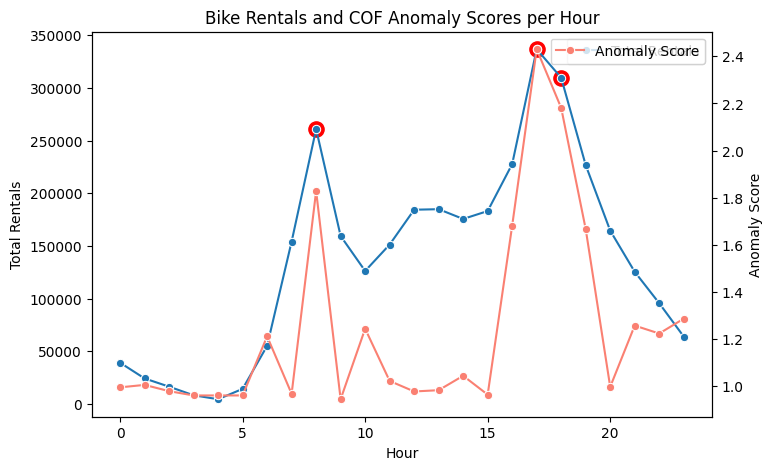

In [143]:
hour_data = hour_data_update.groupby("hr")["cnt"].sum().reset_index()
data_rentals = hour_data[["cnt"]].values

data_std = standardizer(data_rentals)
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

hour_data["AnomalyLabel"] = lof.fit_predict(data_std)
hour_data["AnomalyLabel"] = hour_data["AnomalyLabel"].map({1:0, -1:1})
hour_data["AnomalyScore"] = -lof.negative_outlier_factor_

fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=hour_data, x="hr", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=hour_data, x="hr", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = hour_data[hour_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["hr"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Hour")
plt.show()

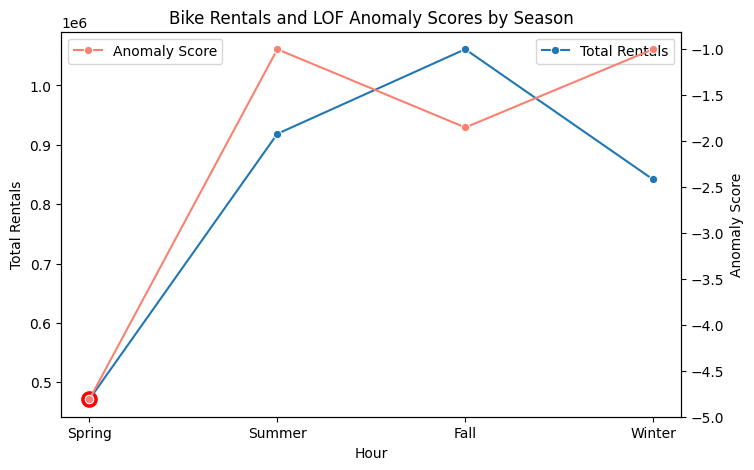

In [146]:
season_data = hour_data_update.groupby("seasonName")["cnt"].sum().reindex(season_order).reset_index()
data_rentals = season_data[["cnt"]].values

data_std = standardizer(data_rentals)
# 25% anomalies as we have 4 seasons, so 1 out of 4
lof = LocalOutlierFactor(n_neighbors=1, contamination=0.25)

season_data["AnomalyLabel"] = lof.fit_predict(data_std)
season_data["AnomalyLabel"] = season_data["AnomalyLabel"].map({1:0, -1:1})
season_data["AnomalyScore"] = lof.negative_outlier_factor_

fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=season_data, x="seasonName", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=season_data, x="seasonName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = season_data[season_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["seasonName"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and LOF Anomaly Scores by Season")
plt.show()

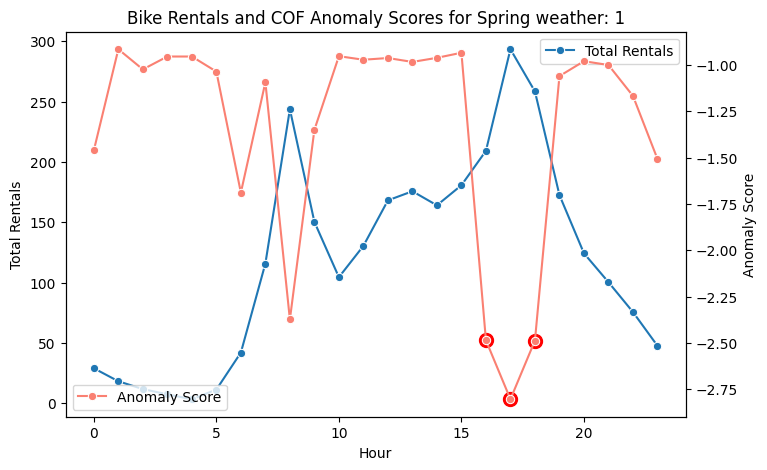

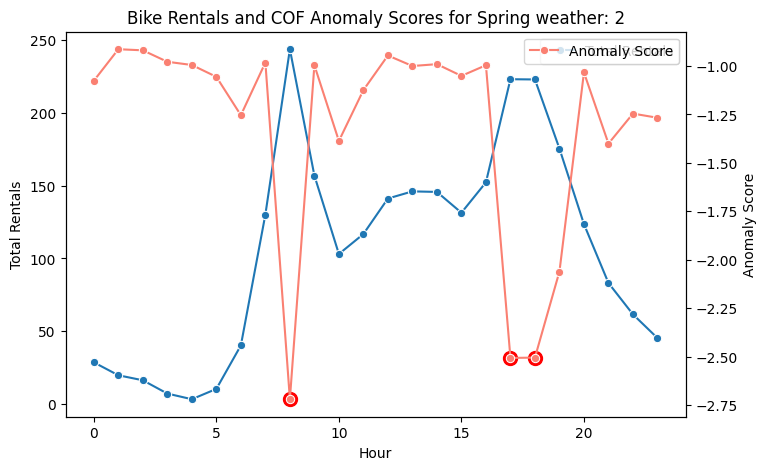

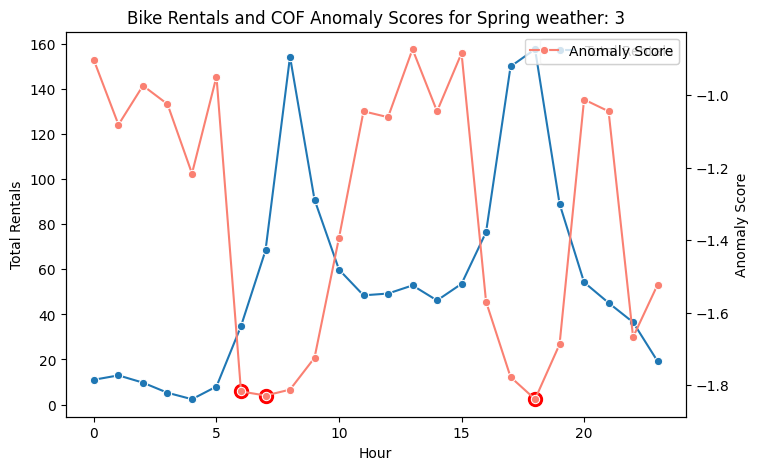

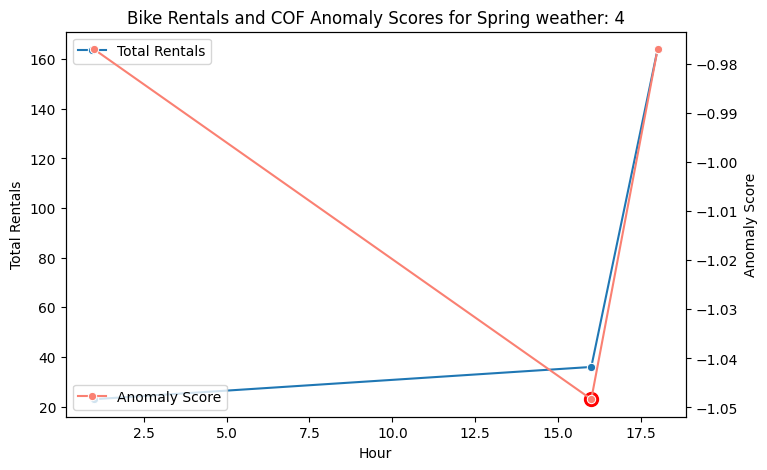

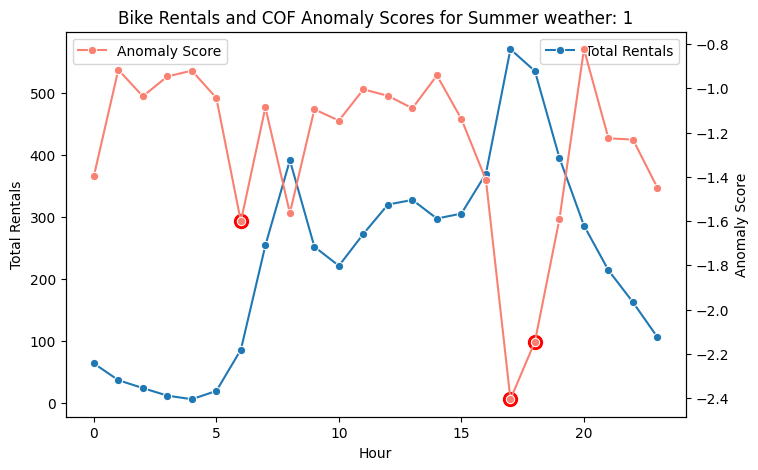

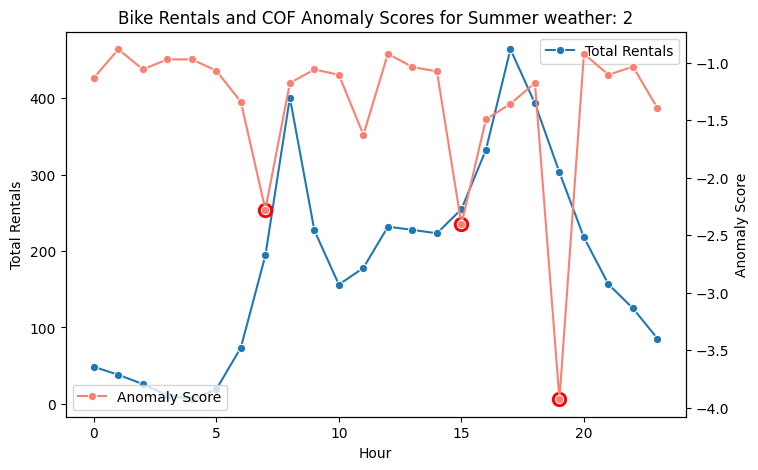

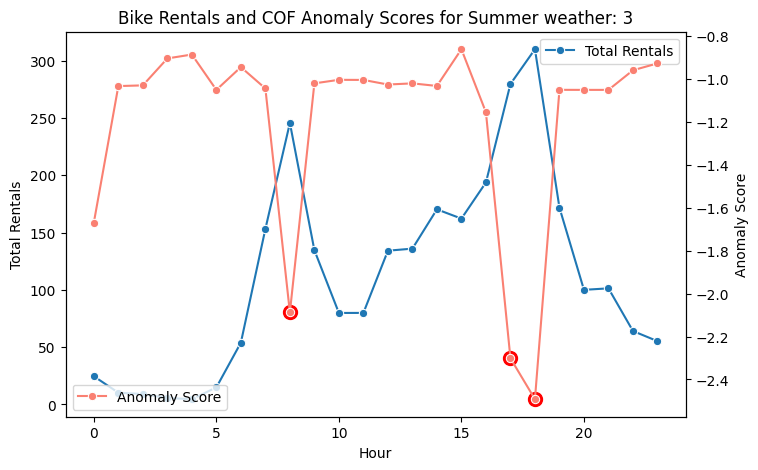

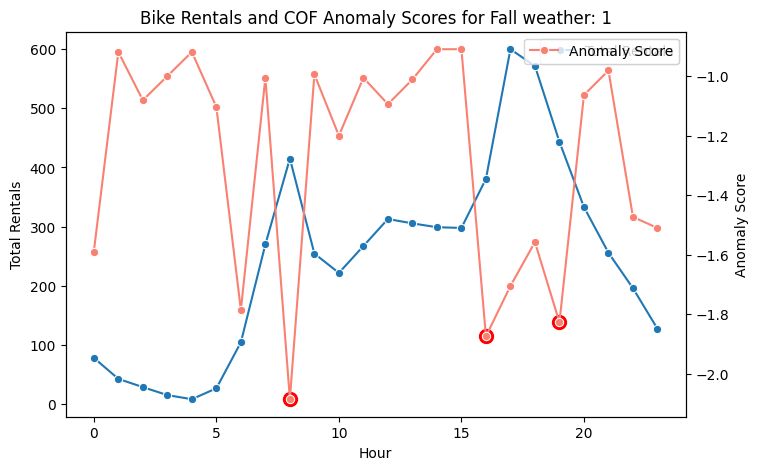

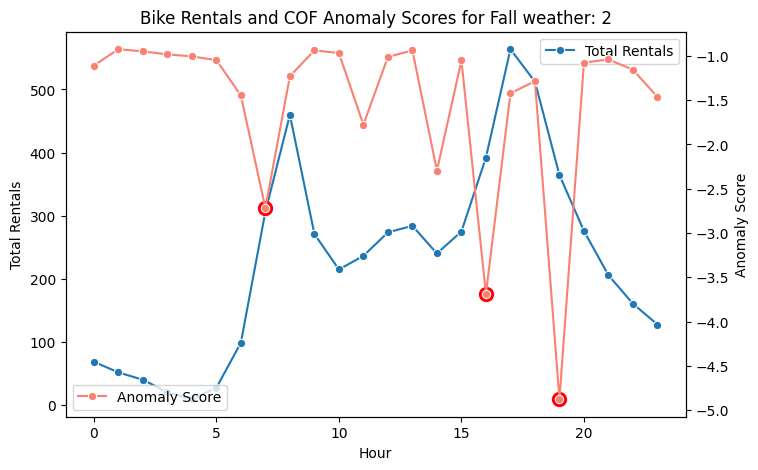

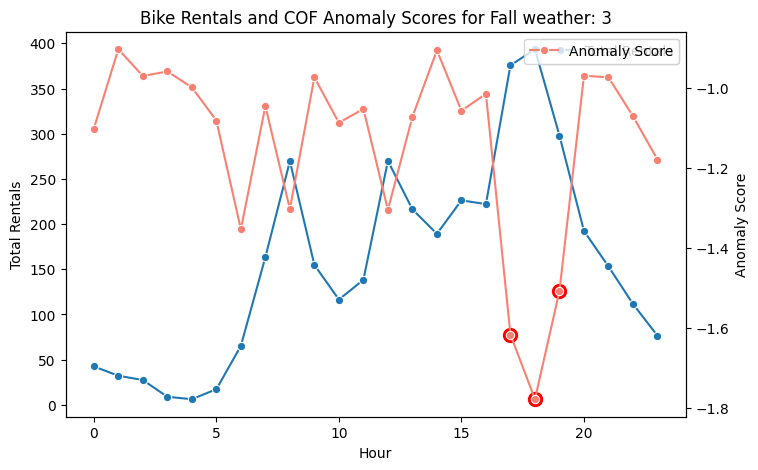

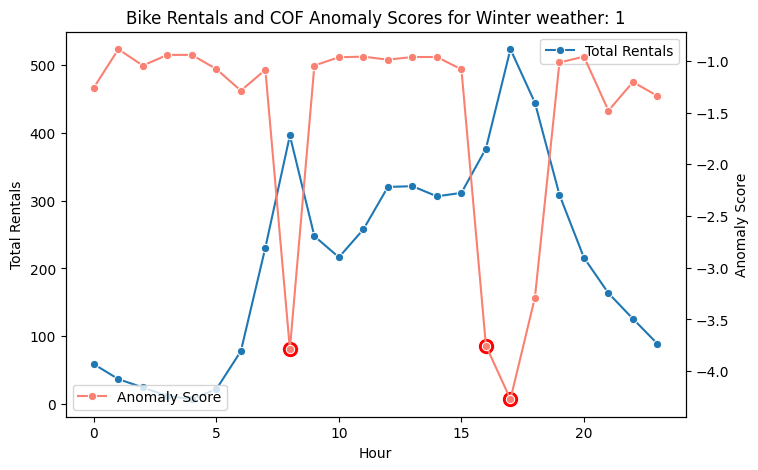

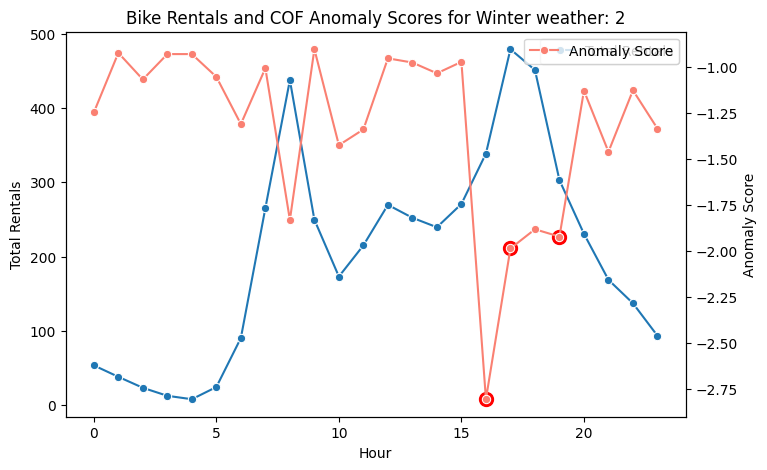

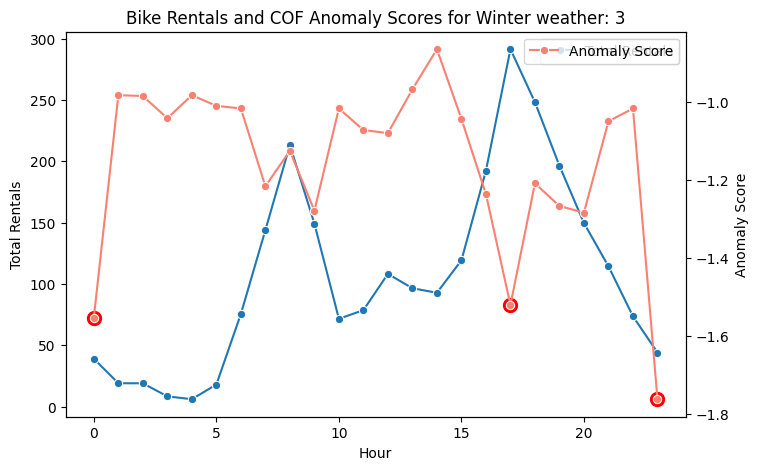

In [185]:
for season in hour_data_update['seasonName'].unique():
    season_data = hour_data_update[hour_data_update['seasonName'] == season]
    hour_weather = season_data.groupby(['hr', 'weathersit'])['cnt'].mean().reset_index()
    hour_weather['AnomalyLabel'] = 0

    for weather in hour_weather['weathersit'].unique():
        subset = hour_weather[hour_weather['weathersit'] == weather].copy()
        data_rentals = subset[['cnt']].values
        
        data_std = standardizer(data_rentals)

        #calculating min as one of the weathers dont have enough data or 4 neighbors
        lof = LocalOutlierFactor(min(4, len(subset)-1), contamination=0.1)
        subset["AnomalyLabel"] = lof.fit_predict(data_std)
        subset["AnomalyLabel"] = subset["AnomalyLabel"].map({1:0, -1:1})
        subset["AnomalyScore"] = lof.negative_outlier_factor_
        fig, ax1 = plt.subplots(figsize=(8,5))
        sns.lineplot(data=subset, x="hr", y="cnt", marker="o", label="Total Rentals", ax=ax1)
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("Total Rentals")
        ax2 = ax1.twinx()
        ax2.set_ylabel("Anomaly Score")
        anomaly = subset[subset["AnomalyLabel"] == 1]
        sns.lineplot(data=subset, x="hr", y="AnomalyScore", marker="o", color="salmon", ax=ax2, label="Anomaly Score")
        ax2.scatter(anomaly["hr"], anomaly["AnomalyScore"], color="red", s=100, label="Anomaly Score")

        plt.title(f"Bike Rentals and COF Anomaly Scores for {season} weather: {weather}")
        plt.show()


Anomaly Detection with COF

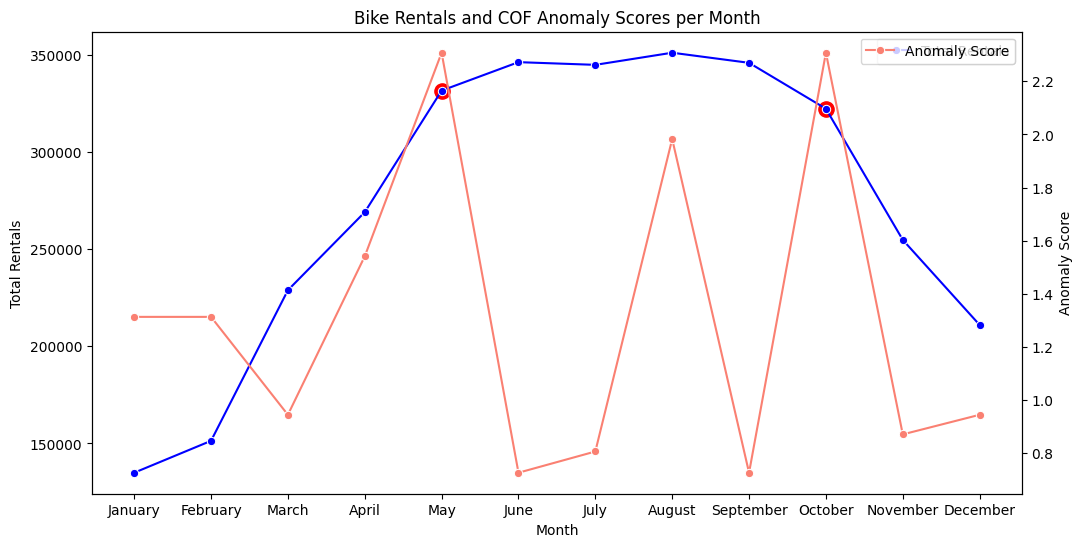

In [136]:
month_data = hour_data_update.groupby("monthName")["cnt"].sum().reindex(month_order).reset_index()
data_rentals = month_data[["cnt"]].values

data_std = standardizer(data_rentals)

cof = COF(n_neighbors=3, contamination=0.1)
cof.fit(data_std)

month_data["AnomalyLabel"] = cof.labels_
month_data["AnomalyScore"] = cof.decision_scores_

fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data=month_data, x="monthName", y="cnt", marker="o", color="blue", label="Total Rentals")
ax1.set_xlabel("Month")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=month_data, x="monthName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = month_data[month_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["monthName"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Month")
plt.show()

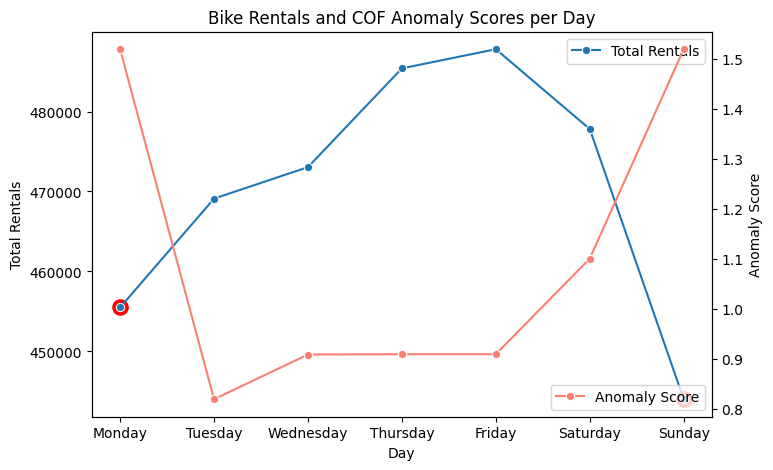

In [142]:
weekday_data = hour_data_update.groupby("dayName")["cnt"].sum().reindex(weekday_order).reset_index()
data_rentals = weekday_data[["cnt"]].values

data_std = standardizer(data_rentals)

cof = COF(n_neighbors=3, contamination=0.25)
cof.fit(data_std)

weekday_data["AnomalyLabel"] = cof.labels_
weekday_data["AnomalyScore"] = cof.decision_scores_

fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=weekday_data, x="dayName", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Day")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=weekday_data, x="dayName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = weekday_data[weekday_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["dayName"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Day")
plt.show()

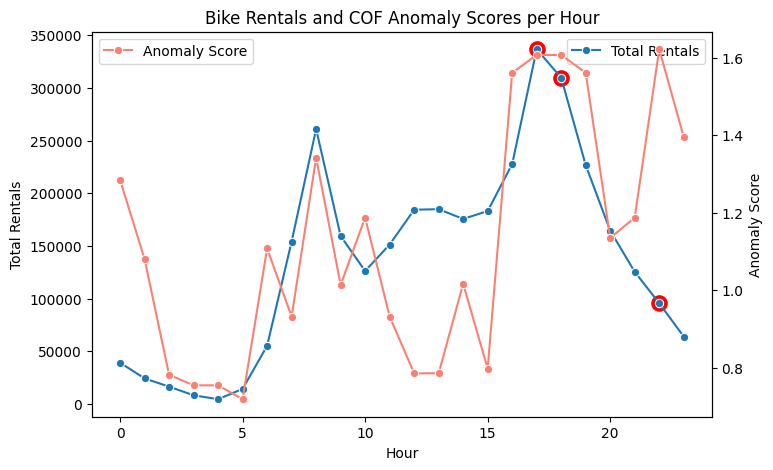

In [ ]:
hour_data = hour_data_update.groupby("hr")["cnt"].sum().reset_index()
data_rentals = hour_data[["cnt"]].values

data_std = standardizer(data_rentals)

cof = COF(n_neighbors=5, contamination=0.1)
cof.fit(data_std)

hour_data["AnomalyLabel"] = cof.labels_
hour_data["AnomalyScore"] = cof.decision_scores_


fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=hour_data, x="hr", y="cnt", marker="o", label="Total Rentals")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=hour_data, x="hr", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score")
ax2.set_ylabel("Anomaly Score")
anomaly = hour_data[hour_data["AnomalyLabel"] == 1]
ax1.scatter(anomaly["hr"], anomaly["cnt"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores per Hour")
plt.show()

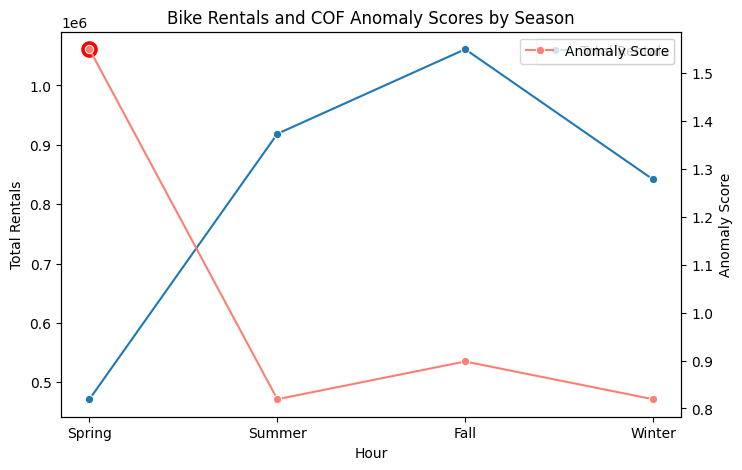

In [190]:
season_data = hour_data_update.groupby("seasonName")["cnt"].sum().reindex(season_order).reset_index()
data_rentals = season_data[["cnt"]].values

data_std = standardizer(data_rentals)

cof = COF(n_neighbors=3, contamination=0.1)
cof.fit(data_std)

season_data["AnomalyLabel"] = cof.labels_
season_data["AnomalyScore"] = cof.decision_scores_

fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=season_data, x="seasonName", y="cnt", marker="o", label="Total Rentals", ax=ax1)
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Rentals")
ax2 = ax1.twinx()
sns.lineplot(data=season_data, x="seasonName", y="AnomalyScore", marker="o", color="salmon", label="Anomaly Score", ax=ax2)
ax2.set_ylabel("Anomaly Score")
anomaly = season_data[season_data["AnomalyLabel"] == 1]
ax2.scatter(anomaly["seasonName"], anomaly["AnomalyScore"], color="red", s=120, label="Anomaly")
plt.title("Bike Rentals and COF Anomaly Scores by Season")
plt.show()

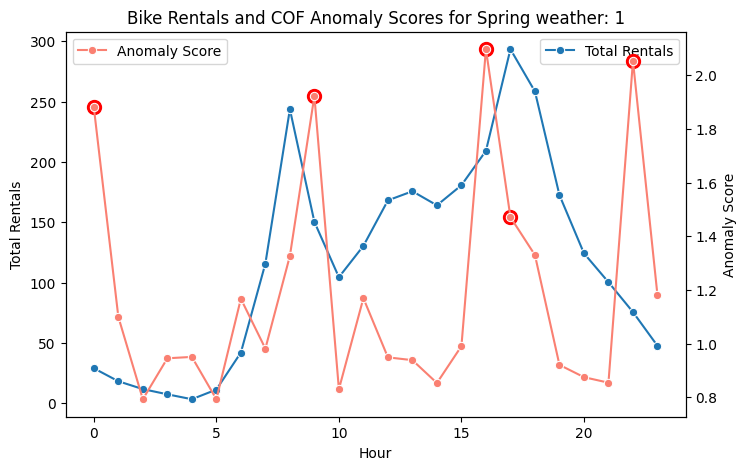

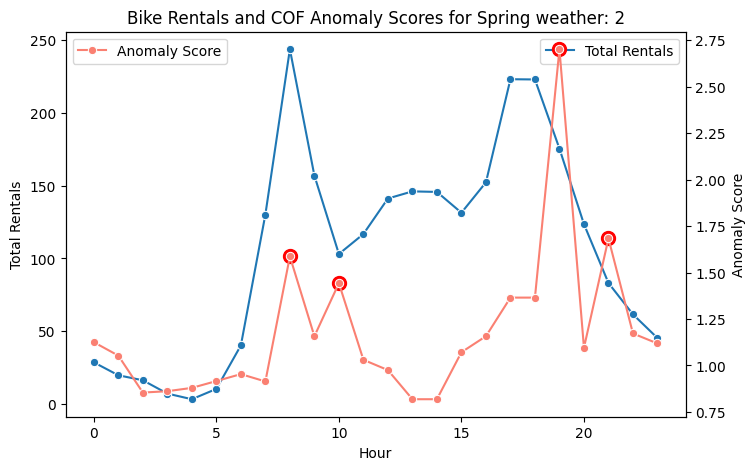

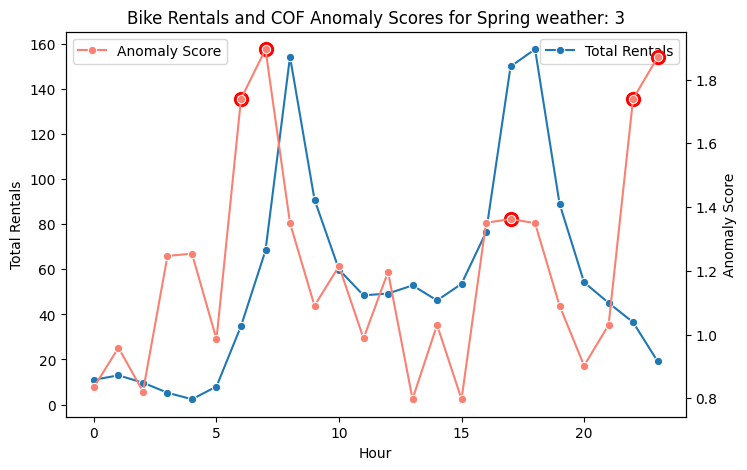

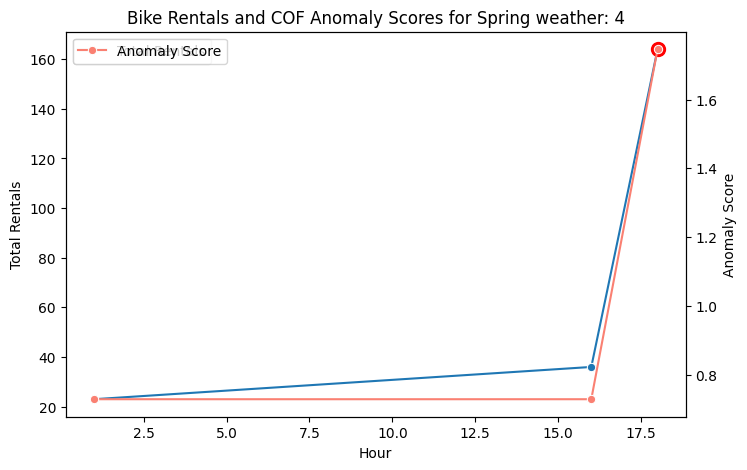

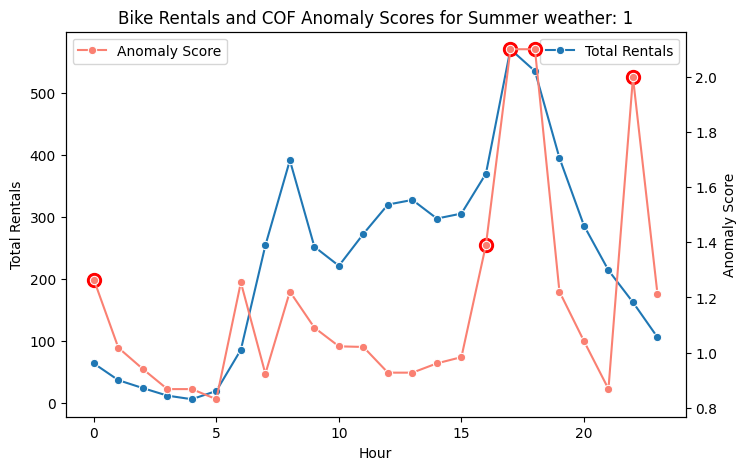

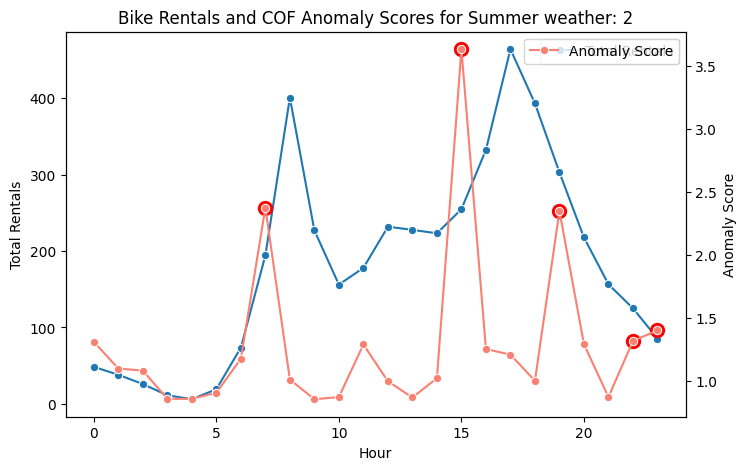

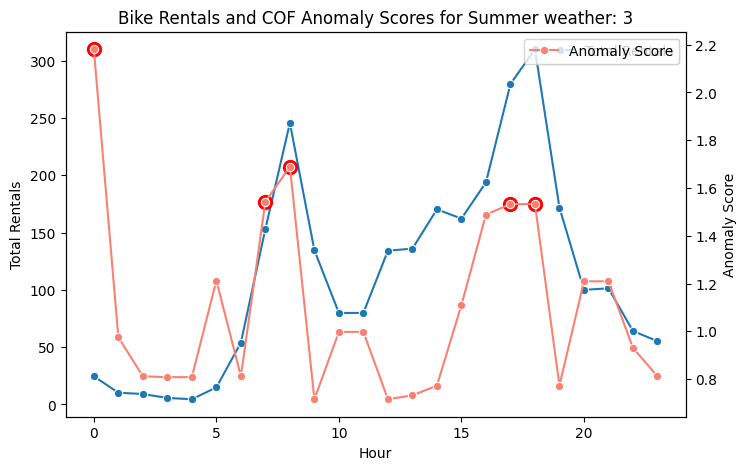

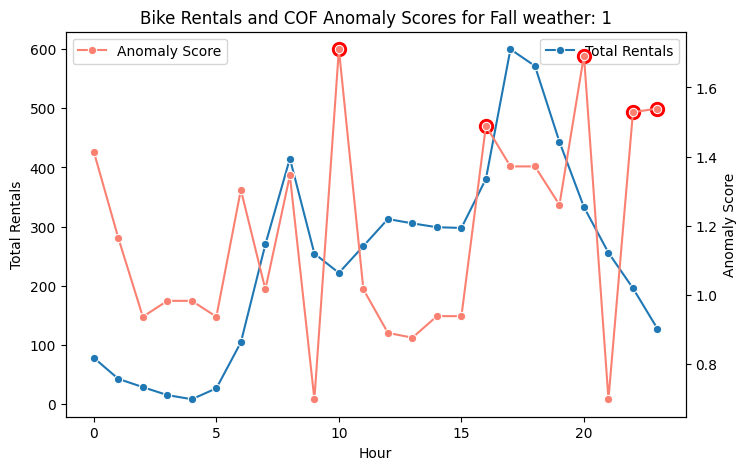

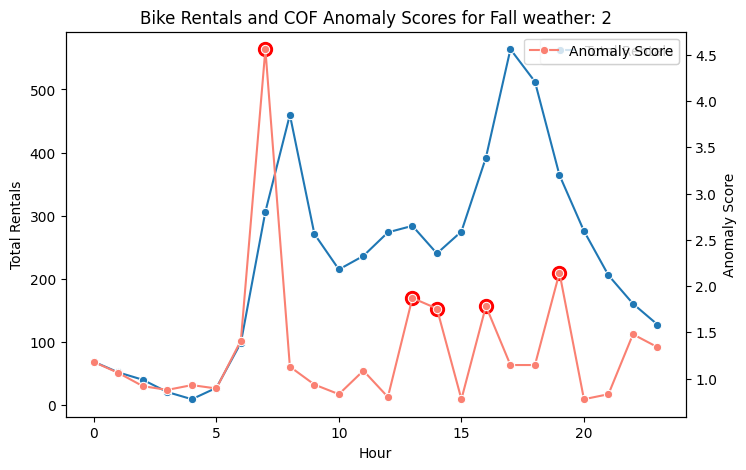

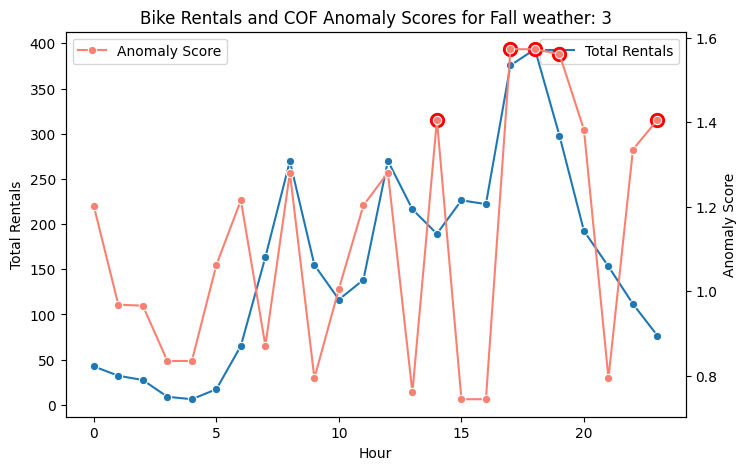

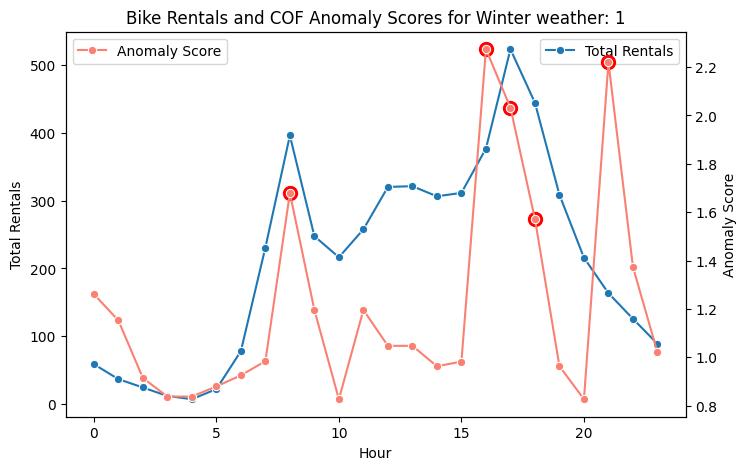

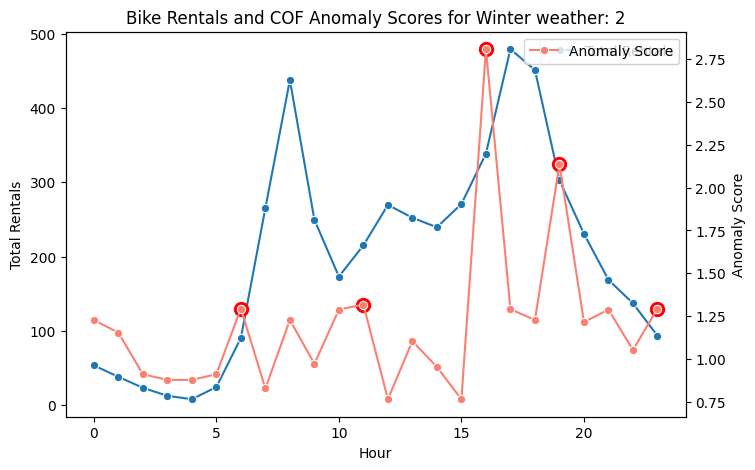

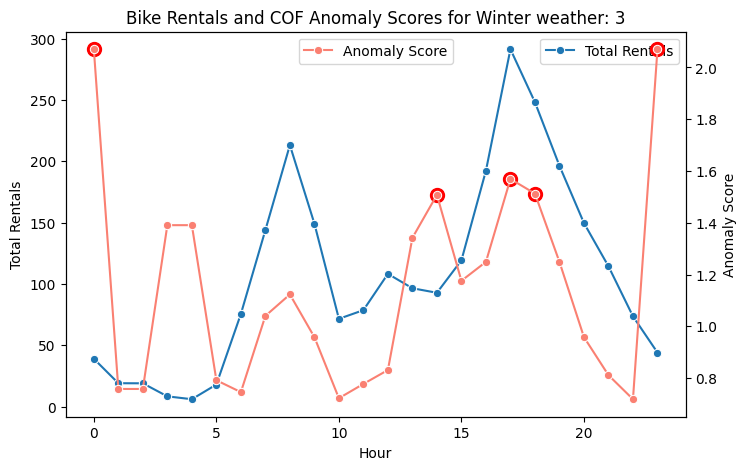

In [186]:
for season in hour_data_update['seasonName'].unique():
    season_data = hour_data_update[hour_data_update['seasonName'] == season]
    hour_weather = season_data.groupby(['hr', 'weathersit'])['cnt'].mean().reset_index()

    hour_weather['AnomalyLabel'] = 0
    hour_weather['AnomalyScore'] = 0.0

    for weather in hour_weather['weathersit'].unique():
        subset = hour_weather[hour_weather['weathersit'] == weather].copy()
        data_rentals = subset[['cnt']].values
        
        data_std = standardizer(data_rentals)

        #calculating min as one of the weathers dont have enough data or 4 neighbors
        cof = COF(n_neighbors=min(4, len(subset)-1), contamination=0.2)
        cof.fit(data_std)
        subset['AnomalyLabel'] = cof.labels_
        subset['AnomalyScore'] = cof.decision_scores_

        fig, ax1 = plt.subplots(figsize=(8,5))
        sns.lineplot(data=subset, x="hr", y="cnt", marker="o", label="Total Rentals", ax=ax1)
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("Total Rentals")
        ax2 = ax1.twinx()
        ax2.set_ylabel("Anomaly Score")
        anomaly = subset[subset["AnomalyLabel"] == 1]
        sns.lineplot(data=subset, x="hr", y="AnomalyScore", marker="o", color="salmon", ax=ax2, label="Anomaly Score")
        ax2.scatter(anomaly["hr"], anomaly["AnomalyScore"], color="red", s=100, label="Anomaly Score")

        plt.title(f"Bike Rentals and COF Anomaly Scores for {season} weather: {weather}")
        plt.show()
